## What Jacot–Gabriel–Hongler tested for NTK convergence in the NTK paper:

- **NTK convergence & (lack of) drift on synthetic data**
  - Inputs lie on the unit circle; visualize the NTK $\Theta(x_0,x)$ at initialization and after training.
  - Compare multiple random initializations across small vs. large widths.
  - Observe variance of the NTK shrinking with width and only mild "inflation" during training that vanishes at large width (i.e., the kernel is effectively constant when wide).

- **Long-time solution matches kernel regression**
  - Tiny least-squares task on a few points on the unit circle.
  - ...

- **Dynamics along NTK principal components (MNIST)**
  - Compute principal components (eigenfunctions) of the NTK.
  - ...

In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt
import numpy as np

import neural_tangents as nt
from neural_tangents import stax

from typing import Callable, Optional, Tuple, List, Union

from utils import *

# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

# Reproduction of NTK paper

## Experiment setup (Jacot–Gabriel–Hongler)

- **Probe manifold: unit circle (2D).**  
  Use angles $\gamma \in [-\pi, \pi)$ and define
  $$
    x(\gamma)=\begin{bmatrix}\cos\gamma\\ \sin\gamma\end{bmatrix}\in\mathbb{R}^2.
  $$
  Build a dense grid $\Gamma=\{\gamma_i\}_{i=1}^{N}$ (e.g., $N=360$) and the probe set $X_{\text{circle}}=\{x(\gamma_i)\}$.
  Fix the **anchor** $x_0=(1,0)$.

- **Regression task used for training (separate from the probe).**  
  Draw inputs $x\sim\mathcal N(0,I_2)$ and set the target
  $$
    f^*(x)=x_1x_2.
  $$
  Train with mean-squared error on this Gaussian dataset. The circle is **only** for measuring/plotting the kernel.

- **Model (finite net).**  
  Fully-connected ReLU MLP in **NTK parameterization** with **depth \(L=4\)**
  Compare **two widths** $n\in\{500,\,10000\}$.

- **Training protocol.**  
  Full-batch gradient descent on the Gaussian regression for **200 steps** with **learning rate 1.0**.  
  Repeat for **10 random initializations** per width (to visualize variability across seeds).

- **What is plotted.**  
  The **empirical NTK** profile
  $$
    \gamma \;\mapsto\; \Theta^{(4)}_{\theta_t}\!\big(x_0,\;x(\gamma)\big)
  $$
  measured on the **unit circle** at two times:
  - **$t=0$** (initialization; solid lines),  
  - **$t=200$** (after training; dotted lines).  
  Plot **all seeds** as thin curves for each width.  

- **Expected observations.**  
  Variance across seeds **shrinks** as width increases (kernel concentrates to a deterministic limit).  
  After training, the NTK shows mild **“inflation”** (overall scale increase), which is **much smaller** for the wide network (kernel ~ constant).


In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt

import neural_tangents as nt
from neural_tangents import stax
import numpy as np

from typing import Callable, Optional, Tuple, List, Union

from matplotlib.ticker import FixedLocator, FixedFormatter, ScalarFormatter

from utils import *

# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# ----------------------------
# 1) Unit circle data
# ----------------------------
N_profile = 360
gamma = jnp.linspace(-jnp.pi, jnp.pi, N_profile, endpoint=False)
X_circle = jnp.stack([jnp.cos(gamma), jnp.sin(gamma)], axis=1)     # [N,2]
x0 = jnp.array([[1.0, 0.0]])                                       # anchor at angle 0 (γ0 = 0)

# A small training set on the circle (task doesn't matter for the profile drift)
M_train = 64
key_tr = random.PRNGKey(123)
idx_tr = random.choice(key_tr, N_profile, shape=(M_train,), replace=False)
X_train = X_circle[idx_tr]
# simple target function used in the paper text examples: f*(x) = x1 * x2
y_train = (X_train[:, 0] * X_train[:, 1])

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


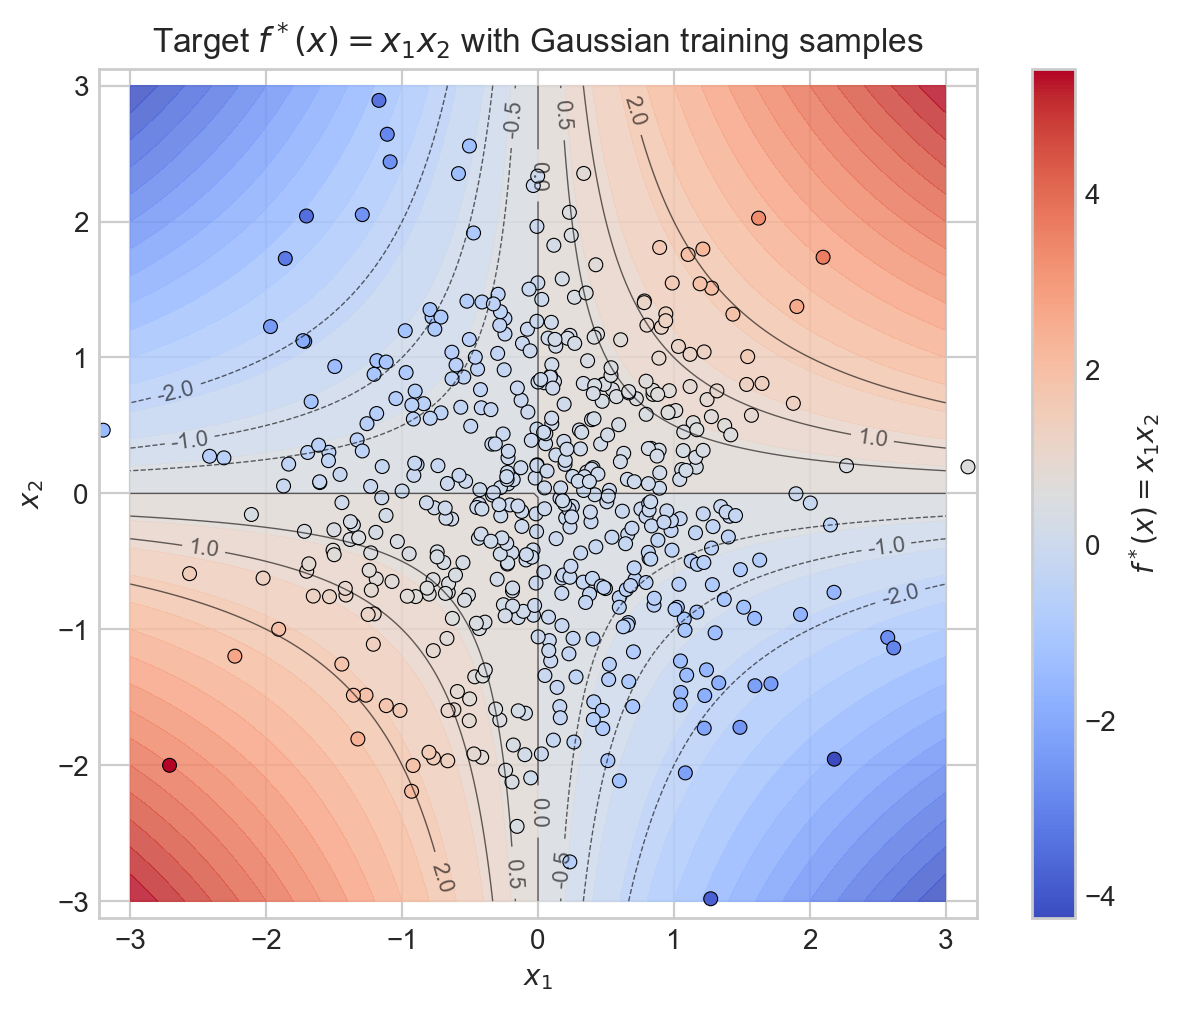

In [3]:
# Generate a Gaussian training set used for the regression task
M_train = 512
key_tr = random.PRNGKey(0)
Xtr = random.normal(key_tr, (M_train, 2))
ytr = Xtr[:, 0] * Xtr[:, 1]   # f*(x) = x1 * x2

# Visualize f*(x) on a grid, with Gaussian samples overlaid
grid_lim, grid_n = 3.0, 201
xx = jnp.linspace(-grid_lim, grid_lim, grid_n)
yy = jnp.linspace(-grid_lim, grid_lim, grid_n)
XX, YY = jnp.meshgrid(xx, yy, indexing='xy')
ZZ = XX * YY   # f*(x, y) = x*y

plt.figure(figsize=(6.2,5.2))
plt.contourf(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
             levels=31, cmap='coolwarm', alpha=0.85)
cs = plt.contour(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
                 levels=[-2,-1,-0.5,0,0.5,1,2], colors='k', linewidths=0.5, alpha=0.6)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

plt.scatter(np.asarray(Xtr[:,0]), np.asarray(Xtr[:,1]),
            c=np.asarray(ytr), cmap='coolwarm', edgecolor='k', linewidths=0.4, s=25)
plt.colorbar(label=r'$f^*(x)=x_1 x_2$')
plt.title('Target $f^*(x)=x_1x_2$ with Gaussian training samples')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.axis('equal')
plt.xlim(-grid_lim, grid_lim); plt.ylim(-grid_lim, grid_lim)
plt.tight_layout(); plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


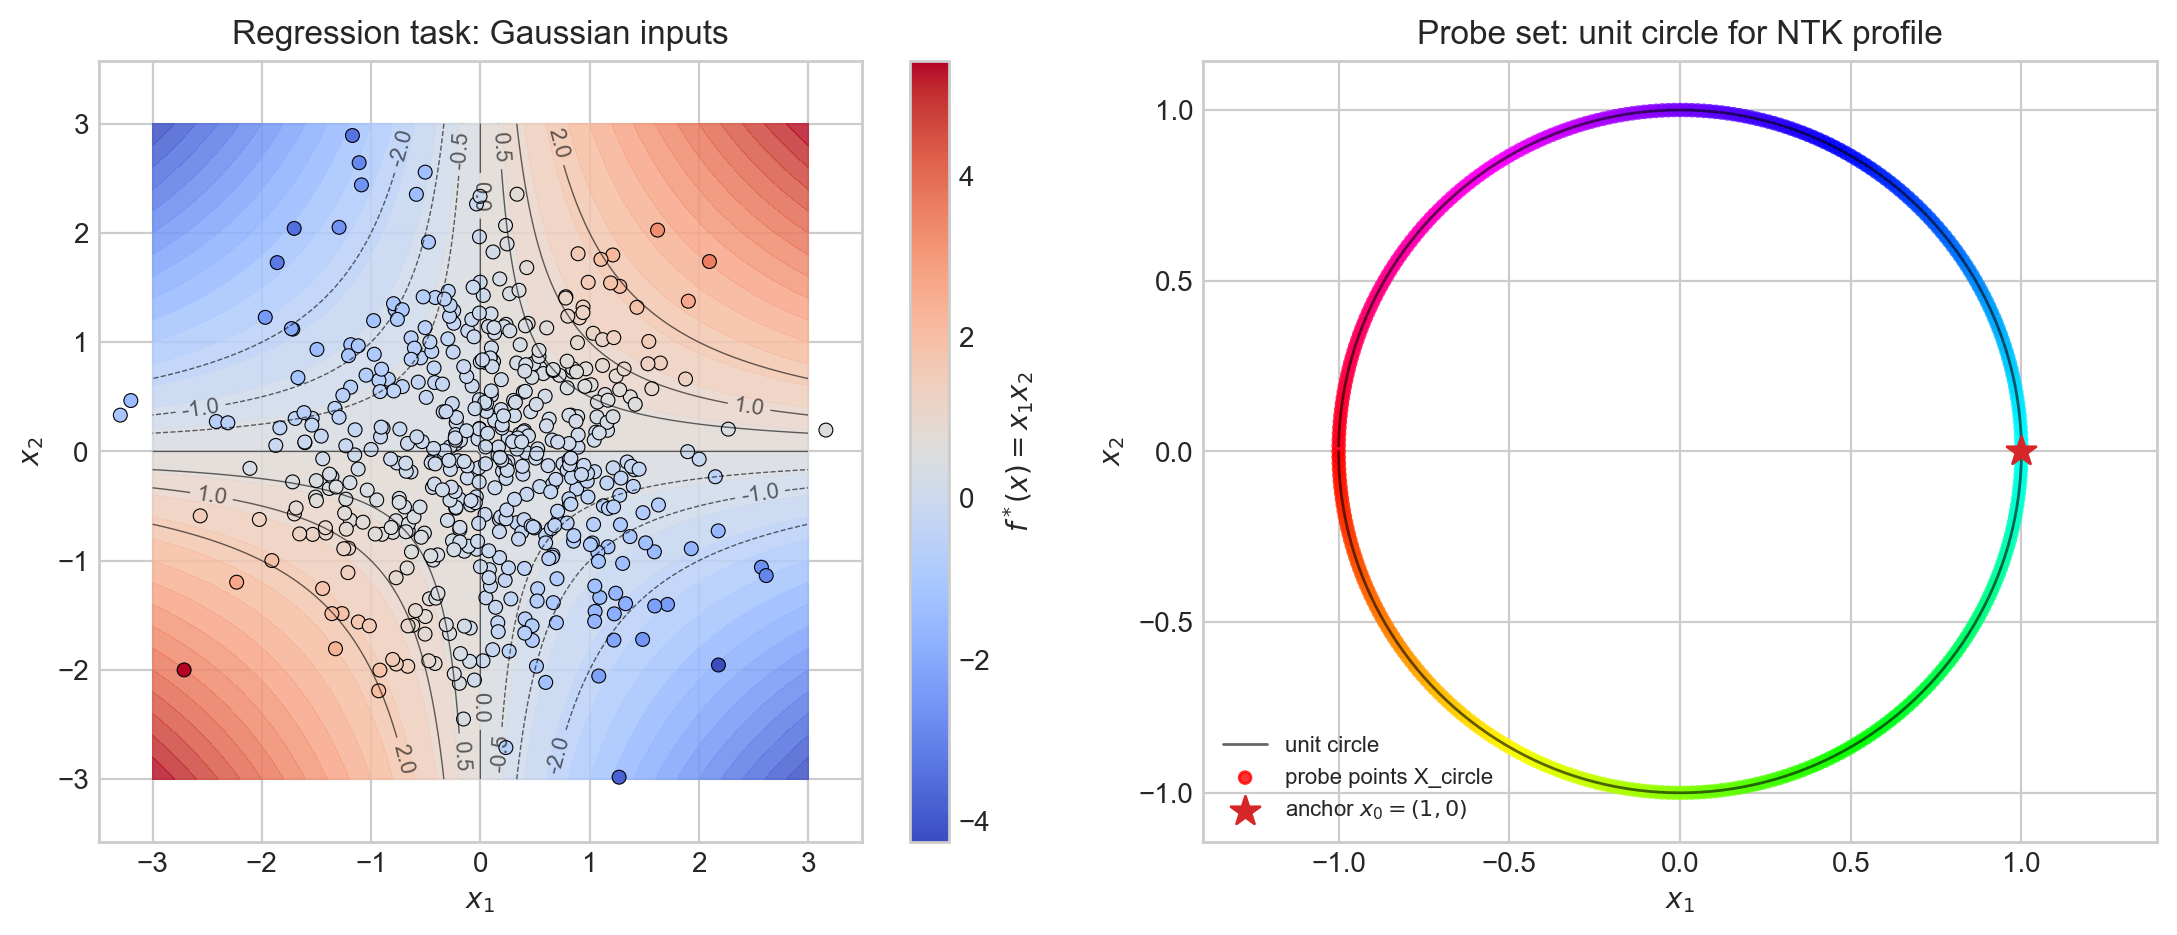

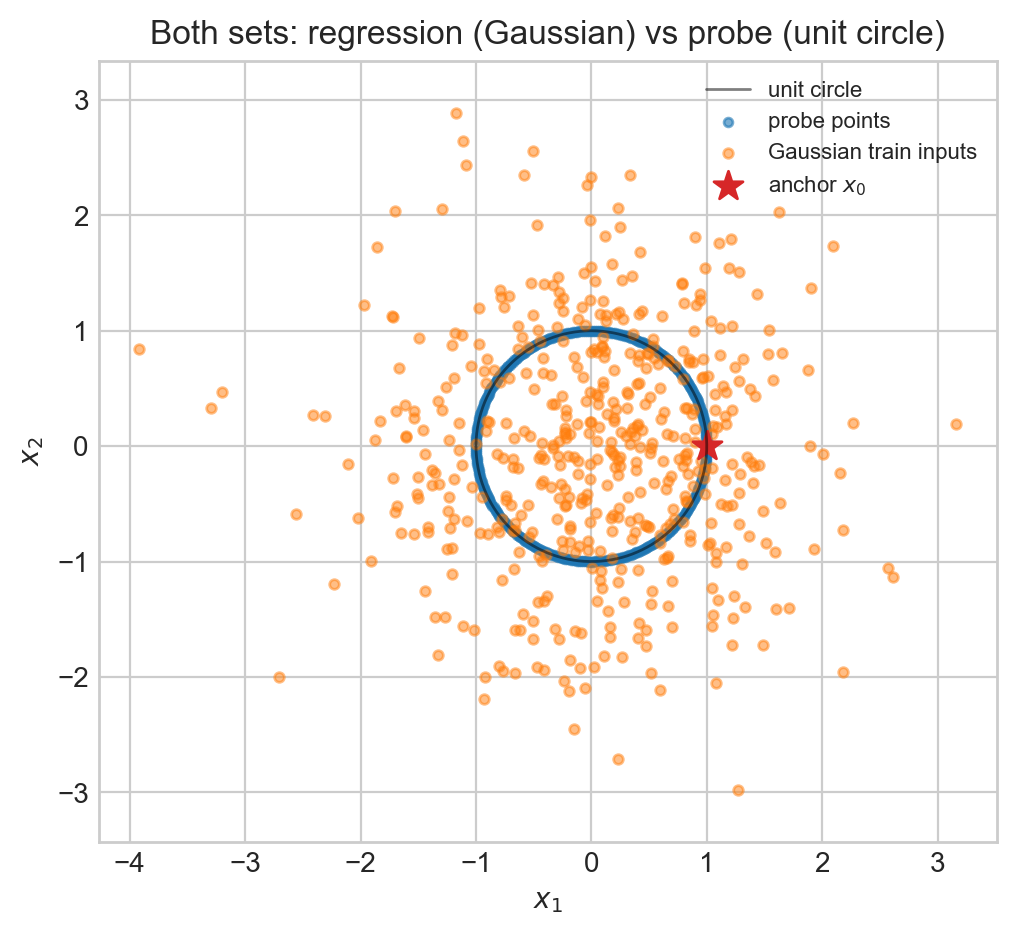

In [4]:
# --- Left: regression task (Gaussian inputs), as you already plotted ---
fig, axs = plt.subplots(1, 2, figsize=(11, 4.8))

# Heatmap of f*(x)=x1*x2 with Gaussian training samples
ax = axs[0]
cntr = ax.contourf(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
                   levels=31, cmap='coolwarm', alpha=0.85)
cs = ax.contour(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
                levels=[-2,-1,-0.5,0,0.5,1,2], colors='k', linewidths=0.5, alpha=0.6)
ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

sc = ax.scatter(np.asarray(Xtr[:,0]), np.asarray(Xtr[:,1]),
                c=np.asarray(ytr), cmap='coolwarm', edgecolor='k', linewidths=0.4, s=25)
fig.colorbar(sc, ax=ax, label=r'$f^*(x)=x_1x_2$')
ax.set_title('Regression task: Gaussian inputs')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.axis('equal')
ax.set_xlim(-grid_lim, grid_lim); ax.set_ylim(-grid_lim, grid_lim)

# --- Right: probe manifold (unit circle) used to measure kernel Θ(x0, x(γ)) ---
ax = axs[1]
# draw the unit circle as a thin line
theta_plot = np.linspace(-np.pi, np.pi, 400, endpoint=False)
ax.plot(np.cos(theta_plot), np.sin(theta_plot), lw=1.0, color='k', alpha=0.6, label='unit circle')

# scatter the discrete probe points used for the profile
# color by angle to make the sweep clear
cmap_vals = (np.asarray(gamma) + np.pi) / (2*np.pi)  # map [-π,π) -> [0,1)
ax.scatter(np.asarray(X_circle[:,0]), np.asarray(X_circle[:,1]),
           c=cmap_vals, cmap='hsv', s=18, alpha=0.8, label='probe points X_circle')

# mark the anchor x0
ax.scatter([1.0],[0.0], marker='*', s=120, color='tab:red', zorder=5, label=r'anchor $x_0=(1,0)$')

ax.set_title('Probe set: unit circle for NTK profile')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.axis('equal')
ax.set_xlim(-1.2, 1.2); ax.set_ylim(-1.2, 1.2)
ax.legend(loc='lower left', fontsize=8)

plt.tight_layout()
plt.show()

plt.figure(figsize=(5.2, 4.8))
plt.plot(np.cos(theta_plot), np.sin(theta_plot), lw=1.0, color='k', alpha=0.5, label='unit circle')
plt.scatter(np.asarray(X_circle[:,0]), np.asarray(X_circle[:,1]),
            s=10, alpha=0.6, label='probe points')
plt.scatter(np.asarray(Xtr[:,0]), np.asarray(Xtr[:,1]),
            s=12, alpha=0.5, label='Gaussian train inputs')
plt.scatter([1.0],[0.0], marker='*', s=120, color='tab:red', label=r'anchor $x_0$')
plt.axis('equal'); plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Both sets: regression (Gaussian) vs probe (unit circle)')
plt.legend(fontsize=8); plt.tight_layout()
plt.savefig("plots/gaussian_vs_circle.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
# ----------------------------
# Empirical NTK profile helper
# ----------------------------
def empirical_profile(apply_fn, params, X_eval, x0):
    """
    Return theta_emp(x0, X_eval) as a vector [len(X_eval)] using Neural Tangents' empirical NTK.
    """
    f = lambda p, x: apply_fn(p, x)           # [B,2] -> [B,1]
    emp_fn = nt.empirical_ntk_fn(f, trace_axes=(), vmap_axes=0)
    prof = emp_fn(x0, X_eval, params).squeeze()   # [1,N] -> [N]
    return prof

In [15]:
# ----------------------------
# 5) Experiment config (narrow vs wide)
# ----------------------------
# Depth L = 4  ->  3 hidden ReLU layers + output
depth_hidden = 1
b_std = 0.1         # paper uses a small bias scale (β ~ 0.1)
widths = [100, 500, 2000]  # if 10k is heavy, use 4096–8192
seeds = 10
train_steps = 200
lr = 1.0            # paper used LR = 1.0
results = {}

In [16]:
# ----------------------------
# 6) Run: for each width, many seeds: profiles at t=0 and t=T
# ----------------------------
for w in widths:
    print(f"Width {w}: computing profiles over {seeds} seeds...")
    init_prof_list, post_prof_list = [], []

    init_fn, apply_fn, kernel_fn = build_mlp(width=w, b_std=b_std, depth_hidden=depth_hidden)

    for s in range(seeds):
        print(f"Seed: {s}")
        # fresh initialization
        _, params0 = init_fn(random.PRNGKey(s), (1, 2))

        # profile at init (t=0)
        prof0 = empirical_profile(apply_fn, params0, X_circle, x0)
        init_prof_list.append(np.asarray(prof0))

        # train on the Gaussian regression task (Xtr, ytr from Cell 2)
        paramsT = train(params0, apply_fn, Xtr, ytr, steps=train_steps, lr=lr, log_every=50)

        # profile after training (t=200)
        profT = empirical_profile(apply_fn, paramsT, X_circle, x0)
        post_prof_list.append(np.asarray(profT))

    # summarize (mean/std across seeds)
    init_arr = np.stack(init_prof_list, axis=0)
    post_arr = np.stack(post_prof_list, axis=0)
    results[w] = {
        "init_all": init_arr, "post_all": post_arr,
        "init_mean": init_arr.mean(0), "init_std": init_arr.std(0),
        "post_mean": post_arr.mean(0), "post_std": post_arr.std(0),
        "kernel_fn": kernel_fn,
    }

Width 100: computing profiles over 10 seeds...
Seed: 0
[train] step    50 | loss=9.648152e-02
[train] step   100 | loss=9.391159e-02
[train] step   150 | loss=9.246901e-02
[train] step   200 | loss=9.154188e-02
Seed: 1
[train] step    50 | loss=9.815521e-02
[train] step   100 | loss=9.553163e-02
[train] step   150 | loss=9.403764e-02
[train] step   200 | loss=9.300409e-02
Seed: 2
[train] step    50 | loss=9.709328e-02
[train] step   100 | loss=9.484843e-02
[train] step   150 | loss=9.385121e-02
[train] step   200 | loss=9.294491e-02
Seed: 3
[train] step    50 | loss=1.005771e-01
[train] step   100 | loss=9.524743e-02
[train] step   150 | loss=9.222662e-02
[train] step   200 | loss=9.054925e-02
Seed: 4
[train] step    50 | loss=9.715696e-02
[train] step   100 | loss=9.390305e-02
[train] step   150 | loss=9.250025e-02
[train] step   200 | loss=9.151881e-02
Seed: 5
[train] step    50 | loss=9.253176e-02
[train] step   100 | loss=9.062774e-02
[train] step   150 | loss=8.951311e-02
[train] 

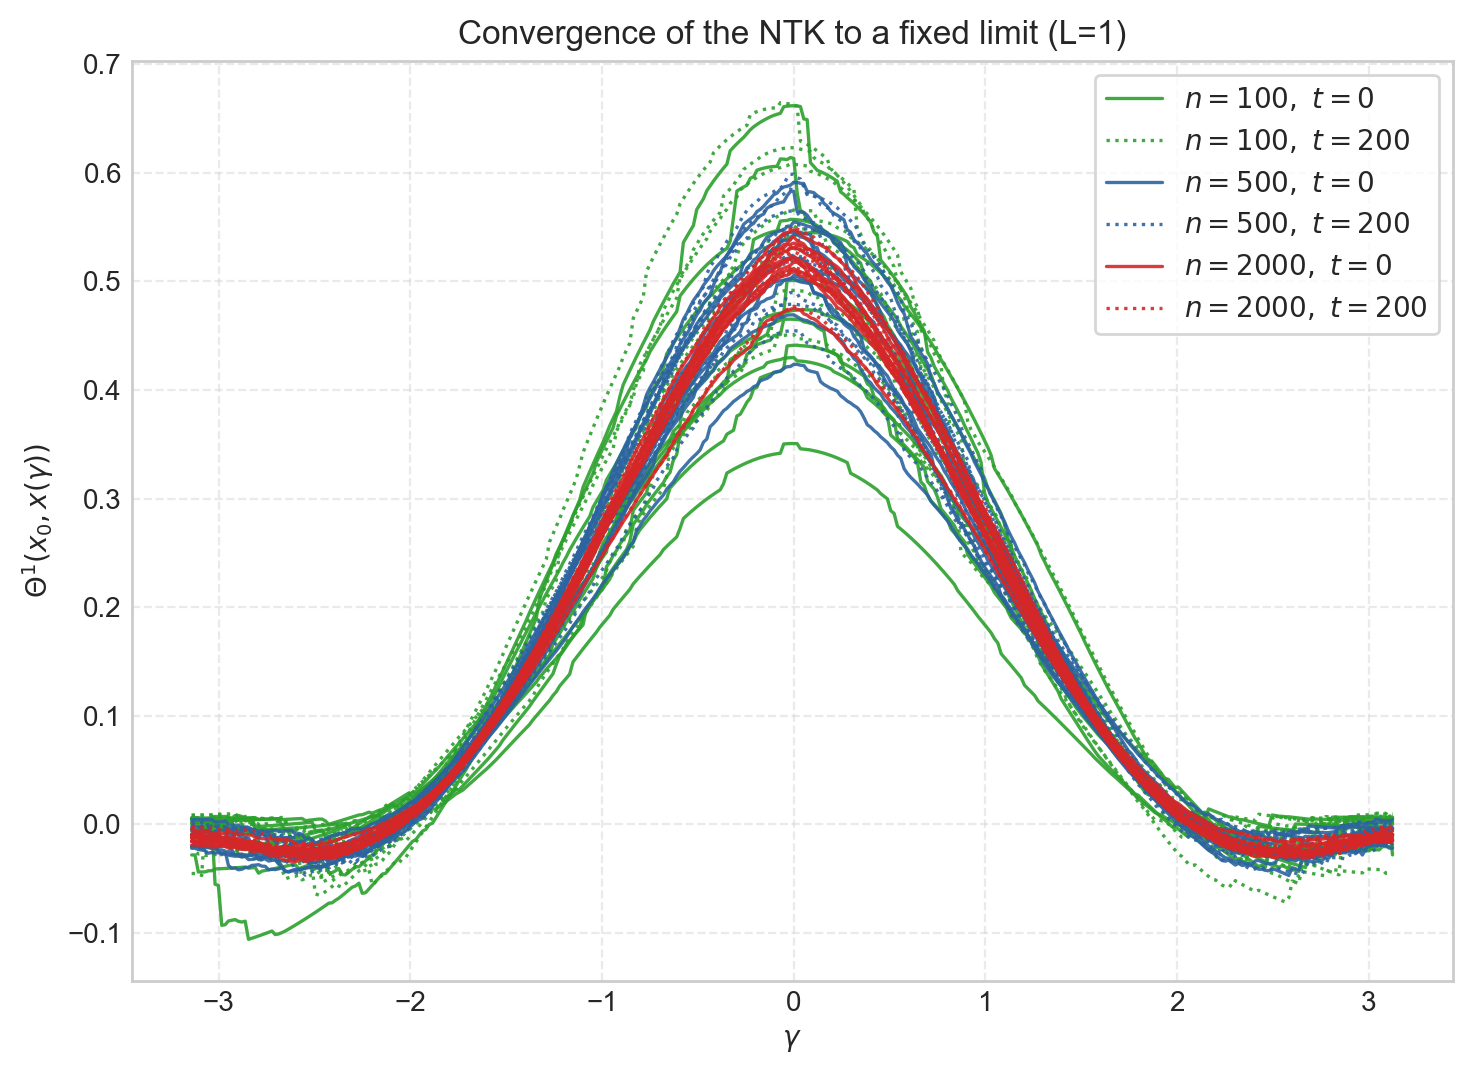

In [20]:
# Analytic (infinity-width) reference profile using the same architecture spec.
# (Any width in build_mlp produces the same analytic kernel_fn under 'ntk'.)
kernel_fn_ref = list(results.values())[0]["kernel_fn"]
theta_inf = np.asarray(kernel_fn_ref(x0, X_circle, get='ntk').squeeze())


# Colors to mimic Fig.1 (green = small width, red = large width)
color_small = "#2ca02c"   # green
color_medium = "#2c64a0" # blue
color_large = "#d62728"   # red
color_map = {widths[0]: color_small, widths[1]: color_medium, widths[-1]: color_large}

plt.figure(figsize=(7.5, 5.5))

for w in widths:
    color = color_map[w]
    R = results[w]

    # plot each seed's curve (t=0 solid, t=200 dotted)
    for k in range(R["init_all"].shape[0]):
        plt.plot(np.asarray(gamma), R["init_all"][k], color=color, lw=1.2, alpha=0.9,
                 label=(fr"$n={w},\ t=0$" if k == 0 else None))
        plt.plot(np.asarray(gamma), R["post_all"][k], color=color, lw=1.2, alpha=0.9, ls=':',
                 label=(fr"$n={w},\ t=200$" if k == 0 else None))

# (optional) overlay analytic NTK as a dashed black curve
# plt.plot(np.asarray(gamma), theta_inf, color='k', lw=1.6, ls='--', label='analytic NTK (∞ width)')

plt.xlabel(r'$\gamma$'); plt.ylabel(f"$\Theta^{(depth_hidden)}(x_0, x(\gamma))$")
plt.title(f"Convergence of the NTK to a fixed limit (L={depth_hidden})")
plt.legend(loc='upper right', frameon=True)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.savefig("plots/ntk-profile.png", dpi=300, bbox_inches="tight")
plt.show()

# Experiment: Do finite-width MLPs converge to the NTK limit?

**Goal.** Replicate classic NTK-style experiments and test whether a trained finite-width ReLU MLP (NTK parameterization) approaches the **infinite-width NTK predictor** as width increases.

---

## Setup

- **Inputs on the unit circle (2D).**  
  For angles $\gamma \in [-\pi, \pi)$,
  $$
    x(\gamma) = \begin{bmatrix}\cos\gamma \\ \sin\gamma\end{bmatrix} \in \mathbb{R}^2.
  $$
  Construct a dense grid $\Gamma = \{\gamma_i\}_{i=1}^N$ and the corresponding dataset $X_{\mathrm{eval}} = \{x(\gamma_i)\}_{i=1}^N$.

- **Targets (two variants).**  
  **(A) Simple baseline (paper-like):** $f^*(x)=x_1x_2$. On the circle this equals $\tfrac{1}{2}\sin(2\gamma)$ (a single low-frequency mode).  
  **(B) Harder mixture (to reveal convergence):**
  $$
    y(\gamma) = \sum_{k\in\mathcal K} a_k\,\sin\!\big(k\,\gamma+\phi_k\big) + \varepsilon,\quad
    \varepsilon \sim \mathcal N(0,\sigma^2),
  $$
  with $\mathcal K$ including higher frequencies (e.g., $\{2,4,7,11,16,23,32\}$), mildly decaying amplitudes $a_k$, and random phases $\phi_k \sim \mathrm{Unif}[0,2\pi)$.  
  *Idea was to (Use (A) for a sanity check; use (B) to better see finite-width $\to$ NTK convergence.)*

- **Train/Test split on the circle.**  
  Select a **small, random** training subset $X_T=\{x(\gamma_{i_j})\}_{j=1}^{M}$ from $X_{\mathrm{eval}}$ (e.g., $M \in \{32, 64, 128, 256\}$).  
  Targets are $y_T = \{y(\gamma_{i_j})\}$.  
  Evaluate on the full grid $X_{\mathrm{eval}}$.  

- **Model (finite net).**  
  Fully-connected ReLU MLP in **NTK parameterization**, depth $L$ (e.g., $L=2$ or $L=4$; keep this fixed), width $n$ swept over
  $\{64,128,256,512,1024,2048,4096,8192\}$.  
  Include **biases**.  
  **Loss:** MSE. **Optimizer:** full-batch GD/SGD with a small learning rate (e.g., $10^{-2}$) to approximate gradient flow; train to near-zero train MSE.

- **Analytic NTK (infinite width).**  
  Build the deterministic limit kernel with  
  `kernel_fn(X, X', get='ntk')` using the **same architecture/activation/parameterization and init hyperparameters**.  
  **NTK predictor (kernel ridge):**
  $$
    \alpha=(K_{TT}+\lambda I)^{-1} y_T,\qquad
    \hat y_{\infty}(X)=K_{XT}\,\alpha,
  $$
  with small $\lambda$ (e.g., $10^{-6}$). $K_{TT}$ is the NTK gram matrix between the training points, $K_{XT}$ is the NTK gram matrix between the test points and the training points. 

- **Across-seed robustness.**  
  For each width, repeat training over multiple random initializations (e.g., 10 seeds); summarize by median and percentile bands.  
  *(Seeds affect finite nets; the analytic NTK predictor does not.)*

---

## Procedure

1. **Generate unit-circle grid** $\Gamma$ and $X_{\mathrm{eval}}$.  
2. **Choose a target**: start with **(A) simple baseline**, then **(B) harder mixture** to see convergence.  
3. **Sample a small random training set** $X_T \subset X_{\mathrm{eval}}$; form $y_T$.  
4. **Compute the analytic NTK predictor** once: $K_{TT}, K_{XT} \to \hat y_{\infty}(X_{\mathrm{eval}})$.  
5. **For each width \(n\):** initialize, train the finite net on $(X_T,y_T)$ with full-batch GD to small MSE; obtain $\hat y_n(X_{\mathrm{eval}})$.  
6. **Compare in function space:**  
   - Overlay $\hat y_n(\gamma)$ and $\hat y_{\infty}(\gamma)$ on $\gamma\in[-\pi,\pi)$.  
   - Record
     $$
       \mathrm{RelErr}(n)=\frac{\|\hat y_n-\hat y_{\infty}\|_2}{\|\hat y_{\infty}\|_2}.
     $$
---

## Expected outcomes & notes

- **Convergence:** As width $n$ increases, $\hat y_n \to \hat y_{\infty}$ and RelErr$(n)$ decreases.
- **Task difficulty:** The simple baseline $x_1x_2=\sin(\gamma)\cos(\gamma)=\tfrac12\sin(2\gamma)$ is **low-frequency** and easy; many widths will already match the NTK closely. The **harder mixture** (with higher modes and fewer train points) should make differences visible at small widths and highlights convergence as $n\uparrow$.  
- **Optimization:** Full-batch GD best mirrors NTK gradient flow.


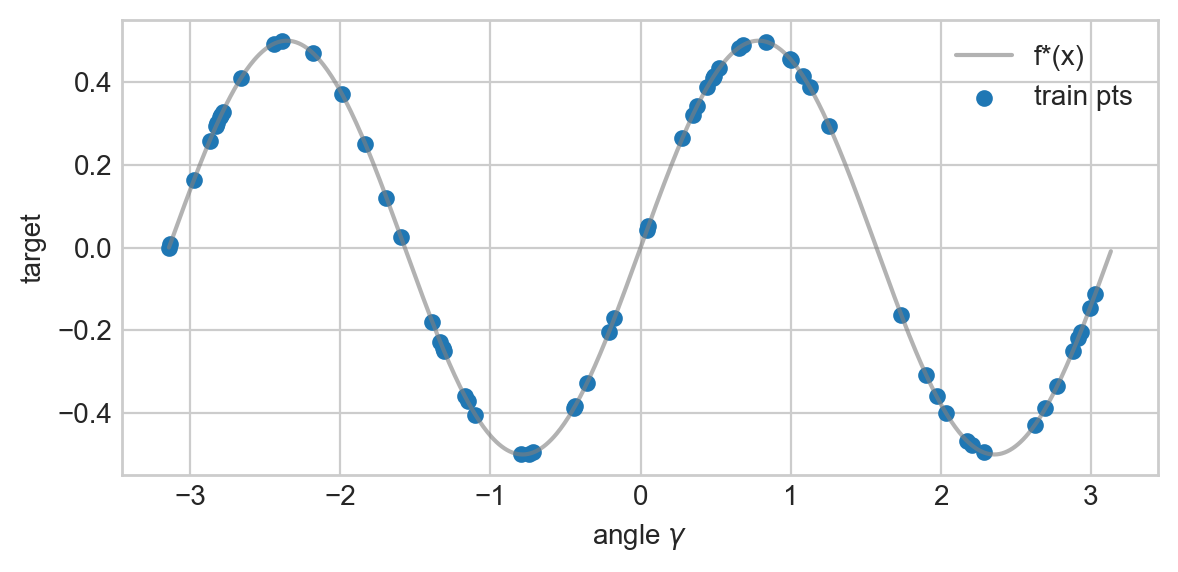

In [9]:
# Probe/eval grid on the circle
N_eval = 720
gamma_eval = jnp.linspace(-jnp.pi, jnp.pi, N_eval, endpoint=False)
X_eval = jnp.stack([jnp.cos(gamma_eval), jnp.sin(gamma_eval)], axis=1)

# Training subset on the circle
M_train = 64                          # try 16 / 64 / 128, etc.
key = random.PRNGKey(0)
idx_tr = random.choice(key, N_eval, shape=(M_train,), replace=False)
X_train = X_eval[idx_tr]

# Ground-truth target; choose any smooth function on the circle
def f_star(X):                        # f*(x)=x1*x2 (same as paper)
    return X[:,0] * X[:,1]

y_train = f_star(X_train)             # [M_train]

# Visualize the regression problem
plt.figure(figsize=(6,3))
plt.plot(np.asarray(gamma_eval), np.asarray(f_star(X_eval)), color='gray', alpha=0.6, label='f*(x)')
plt.scatter(np.asarray(gamma_eval[idx_tr]), np.asarray(y_train), s=25, label='train pts')
plt.xlabel(r'angle $\gamma$'); plt.ylabel('target'); plt.legend(); plt.tight_layout(); 
plt.savefig("plots/simple-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
X_train.shape, y_train.shape

((64, 2), (64,))

In [11]:
depth_hidden = 1   # L = depth_hidden + 1 (output). Here: 1 hidden layer + output.
b_std = 0.1
lr = 1e-2
steps = 30_000
widths = [512, 1024, 2048, 4096, 8192]  # 16384/32768 may be very heavy; add if feasible.
seeds = list(range(10))                 # 10 random initializations

# 1) Build ONE analytic kernel (width-independent under 'ntk') and compute NTK predictor once.
_, _, kernel_fn_ref = build_mlp(width=512, b_std=b_std, depth_hidden=depth_hidden)
reg = 1e-6
K_tt = kernel_fn_ref(X_train, X_train, get='ntk')
K_xt = kernel_fn_ref(X_eval,  X_train, get='ntk')
alpha = jnp.linalg.solve(K_tt + reg * jnp.eye(K_tt.shape[0]), y_train[:, None])
y_inf = (K_xt @ alpha).squeeze()    # [N_eval]

In [12]:
def relerr(a, b):
    return float(jnp.linalg.norm(a - b) / (jnp.linalg.norm(b) + 1e-12))

# 2) Run sweep: for each width, train across seeds and collect predictions/errors.
stats = {}           # width -> dict of arrays
errs_summary = []    # (width, mean_err, p10, p50, p90)

for w in widths:
    print(f"\n=== width {w} ===")
    preds_w = []   # [n_seeds, N_eval]
    errs_w  = []   # [n_seeds]

    init_fn, apply_fn, _ = build_mlp(width=w, b_std=b_std, depth_hidden=depth_hidden)

    for s in seeds:
        print(f"------ Seed: {s} ------")
        # fresh init per seed
        _, params0 = init_fn(random.PRNGKey(s), X_train.shape)
        # train on SAME (X_train, y_train)
        params = train(params0, apply_fn, X_train, y_train, steps=steps, lr=lr, log_every=5000)
        # predictions on full circle
        y_fin = apply_fn(params, X_eval).squeeze()
        preds_w.append(np.asarray(y_fin))
        errs_w.append(relerr(y_fin, y_inf))

    preds_w = np.stack(preds_w, axis=0)                 # [S, N_eval]
    errs_w = np.asarray(errs_w)                         # [S]

    stats[w] = {
        "preds": preds_w,
        "err_all": errs_w,
        "pred_mean": preds_w.mean(0),
        "pred_p10":  np.percentile(preds_w, 10, axis=0),
        "pred_p50":  np.percentile(preds_w, 50, axis=0),
        "pred_p90":  np.percentile(preds_w, 90, axis=0),
    }

    mean_err = float(errs_w.mean())
    p10, p50, p90 = np.percentile(errs_w, [10, 50, 90])
    errs_summary.append((w, mean_err, p10, p50, p90))
    print(f"[eval] RelErr(finite vs NTK): mean={mean_err:.3e} | p50={p50:.3e} | p10={p10:.3e} | p90={p90:.3e}")

# 3) Error vs width (with percentiles across seeds).
ws   = np.array([x[0] for x in errs_summary])
merr = np.array([x[1] for x in errs_summary])
p10  = np.array([x[2] for x in errs_summary])
p50  = np.array([x[3] for x in errs_summary])
p90  = np.array([x[4] for x in errs_summary])


=== width 512 ===
------ Seed: 0 ------
[train] step  5000 | loss=8.118231e-04
[train] step 10000 | loss=5.819748e-04
[train] step 15000 | loss=4.497880e-04
[train] step 20000 | loss=3.606430e-04
[train] step 25000 | loss=2.969744e-04
[train] step 30000 | loss=2.505345e-04
------ Seed: 1 ------
[train] step  5000 | loss=2.559172e-04
[train] step 10000 | loss=1.138870e-04
[train] step 15000 | loss=9.869115e-05
[train] step 20000 | loss=8.710641e-05
[train] step 25000 | loss=7.772060e-05
[train] step 30000 | loss=6.994238e-05
------ Seed: 2 ------
[train] step  5000 | loss=7.793600e-04
[train] step 10000 | loss=2.356925e-04
[train] step 15000 | loss=1.646545e-04
[train] step 20000 | loss=1.237077e-04
[train] step 25000 | loss=9.844035e-05
[train] step 30000 | loss=8.172143e-05
------ Seed: 3 ------
[train] step  5000 | loss=6.129506e-04
[train] step 10000 | loss=3.394930e-04
[train] step 15000 | loss=2.397199e-04
[train] step 20000 | loss=1.772350e-04
[train] step 25000 | loss=1.370052e

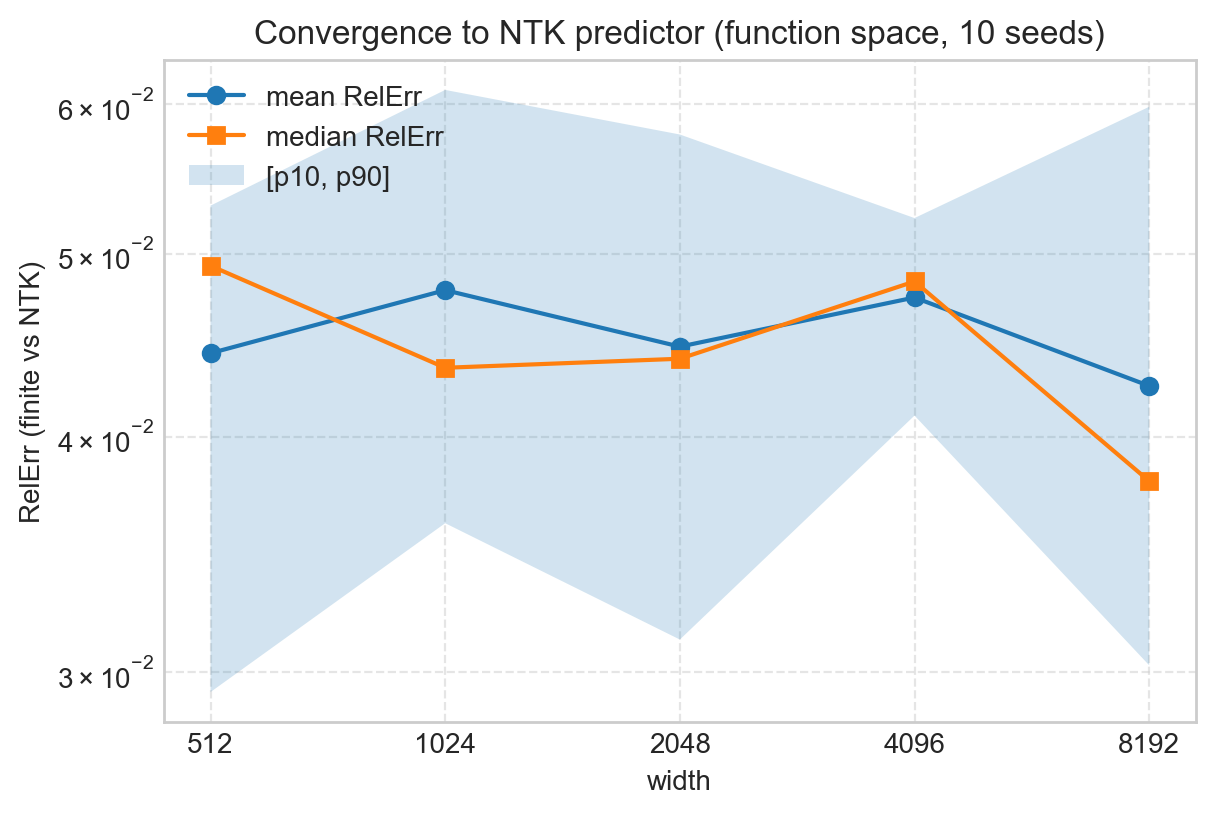

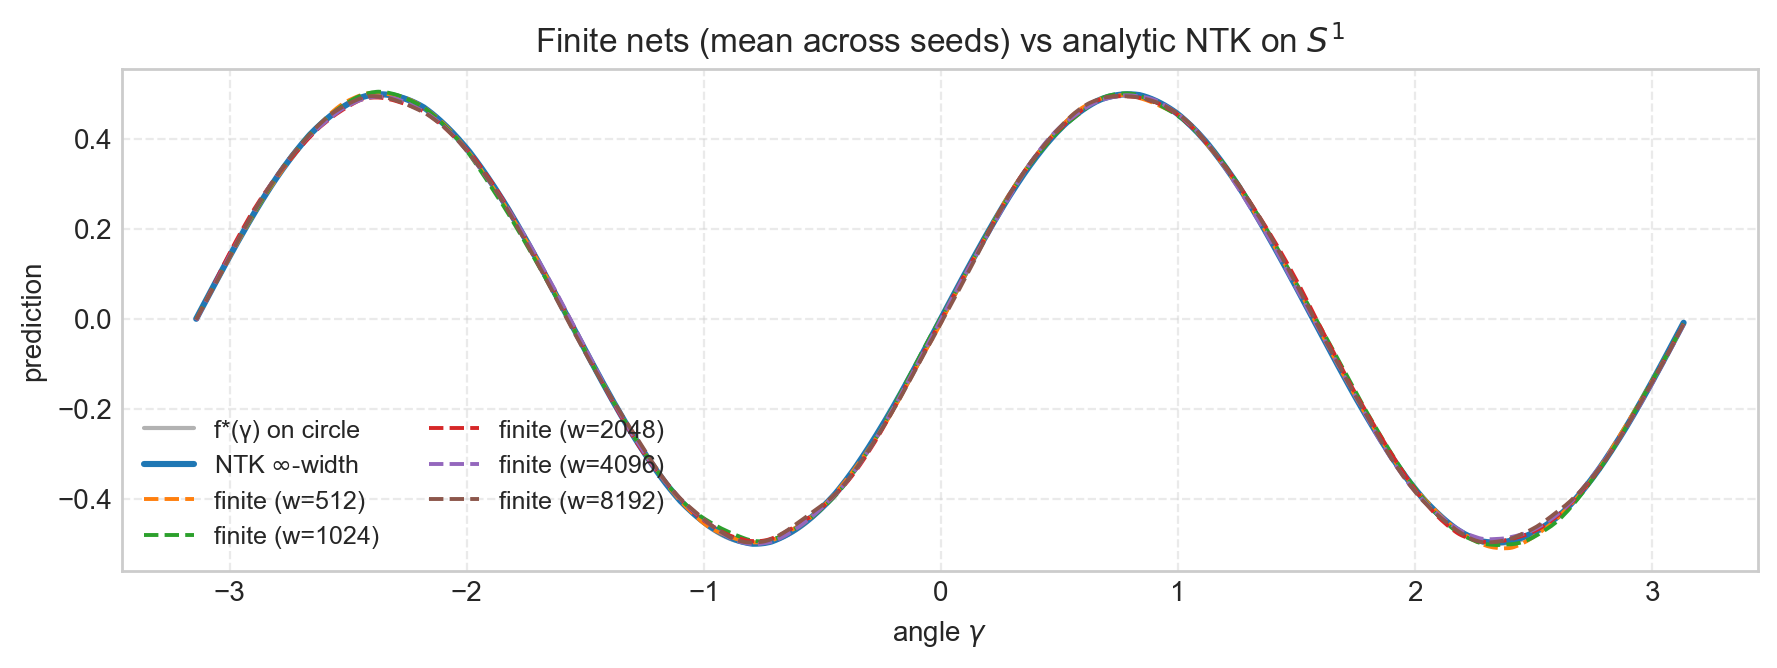

In [14]:
# plt.figure(figsize=(6.2,4.2))
# plt.loglog(ws, merr, marker='o', label='mean RelErr')
# plt.loglog(ws, p50, marker='s', label='median RelErr')
# plt.fill_between(ws, p10, p90, alpha=0.2, label='[p10, p90]')
# plt.xlabel('width'); plt.ylabel('RelErr (finite vs NTK)')
# plt.title('Convergence to NTK predictor (function space, 10 seeds)')
# plt.grid(True, which='both', ls='--', alpha=0.5); plt.legend()
# plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.loglog(ws, merr, marker='o', label='mean RelErr')
ax.loglog(ws, p50, marker='s', label='median RelErr')
ax.fill_between(ws, p10, p90, alpha=0.2, label='[p10, p90]')

# --- set ticks/labels on log-x ---
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(widths))
ax.xaxis.set_major_formatter(FixedFormatter([str(w) for w in widths]))
ax.xaxis.set_minor_locator(FixedLocator([]))

ax.set_xlabel('width')
ax.set_ylabel('RelErr (finite vs NTK)')
ax.set_title('Convergence to NTK predictor (function space, 10 seeds)')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()
fig.tight_layout()
plt.savefig("plots/rel-err-on-simple-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()

# 4) Overlay predictions: show NTK curve + per-width median (p50) and band (p10/p90).
gamma_np = np.asarray(gamma_eval)

# for w in widths:
#     s = stats[w]
#     plt.figure(figsize=(9,3.5))
#     plt.plot(gamma_np, np.asarray(y_inf), lw=2.2, label="NTK $\infty$-width")
#     plt.plot(gamma_np, s["pred_p50"], '--', lw=1.8, label=f'finite (w={w}) median')
#     plt.fill_between(gamma_np, s["pred_p10"], s["pred_p90"], alpha=0.15, label='finite p10–p90')
#     plt.xlabel(r'angle $\gamma$'); plt.ylabel('prediction')
#     plt.title(f'Finite nets vs analytic NTK on $S^1$ (width={w}, 10 seeds)')
#     plt.legend(); plt.grid(True, ls='--', alpha=0.4); plt.tight_layout(); plt.show()

# Overlay predictions
plt.figure(figsize=(9,3.5))
plt.plot(np.asarray(gamma_eval), np.asarray(f_star(X_eval)), color='gray', alpha=0.6, label='f*(γ) on circle')
plt.plot(np.asarray(gamma_eval), np.asarray(y_inf), lw=2.2, label="NTK $\infty$-width")
for w in widths:
    s = stats[w]
    plt.plot(np.asarray(gamma_eval), s["preds"].mean(axis=0), '--', lw=1.4, label=f'finite (w={w})')
plt.xlabel(r'angle $\gamma$'); plt.ylabel('prediction')
plt.title('Finite nets (mean across seeds) vs analytic NTK on $S^1$')
plt.legend(ncol=2, fontsize=9); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout(); 
plt.savefig("plots/convergence-on-simple-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()

## Using a more complex dataset

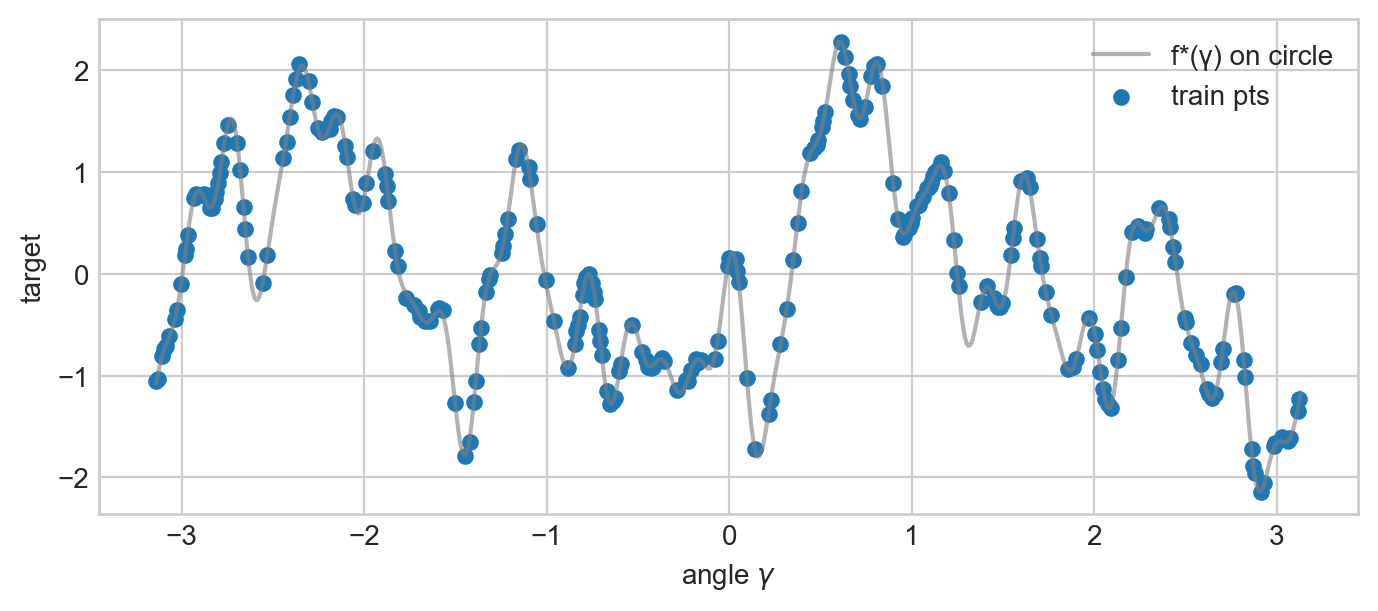

In [2]:
# ========== Harder supervised task on the circle ==========

# Probe/eval grid on the circle
N_eval = 720
gamma_eval = jnp.linspace(-jnp.pi, jnp.pi, N_eval, endpoint=False)
X_eval = jnp.stack([jnp.cos(gamma_eval), jnp.sin(gamma_eval)], axis=1)

# Choose a richer target as a Fourier mixture
# - higher frequencies force use of smaller NTK eigenvalues (harder)
# - random phases prevent symmetry shortcuts
key_t = random.PRNGKey(123)
Ks = jnp.array([2, 4, 7, 11, 16, 23, 32])           # include some higher k
# amplitudes with mild decay so highs matter but don't dominate
amps = jnp.array([0.9, 0.7, 0.55, 0.45, 0.35, 0.28, 0.22])
phases = random.uniform(key_t, shape=Ks.shape, minval=0.0, maxval=2*jnp.pi)

def f_star_gamma(g):
    A = Ks[:, None] * g[None, :] + phases[:, None]   # (7,N)
    return jnp.einsum('k,kN->N', amps, jnp.sin(A))   # (N,)

# ground truth on the eval grid
y_eval_true = f_star_gamma(gamma_eval)

# Training subset: make it sparse to stress generalization
M_train = 256   # try 32/64/128
key = random.PRNGKey(0)
idx_tr = random.choice(key, N_eval, shape=(M_train,), replace=False)
X_train = X_eval[idx_tr]
gamma_train = gamma_eval[idx_tr]
y_train = f_star_gamma(gamma_train)

# add small label noise
sigma_y = 0.02
y_train = y_train + sigma_y * random.normal(random.PRNGKey(1), y_train.shape)

# Visualize the regression problem
plt.figure(figsize=(7,3.2))
plt.plot(np.asarray(gamma_eval), np.asarray(y_eval_true), color='gray', alpha=0.6, label='f*(γ) on circle')
plt.scatter(np.asarray(gamma_train), np.asarray(y_train), s=25, label='train pts')
plt.xlabel(r'angle $\gamma$'); plt.ylabel('target'); plt.legend(); plt.tight_layout(); 
plt.savefig("plots/complex-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()

# For code downstream that expects f*(X): convenience wrapper
def f_star(X):
    # X = [N,2] points on circle -> map to γ
    g = jnp.arctan2(X[:,1], X[:,0])
    # ensure g in [-π, π); arctan2 already does that
    return f_star_gamma(g)


In [3]:
depth_hidden = 1   # L = depth_hidden + 1 (output). Here: 1 hidden layer + output.
b_std = 0.1
lr = 1e-2
steps = 30_000
widths = [512, 1024, 2048, 4096, 8192, 16384]  # 16384/32768 may be very heavy; add if feasible.
seeds = list(range(10))                 # 10 random initializations

# 1) Build ONE analytic kernel (width-independent under 'ntk') and compute NTK predictor once.
_, _, kernel_fn_ref = build_mlp(width=512, b_std=b_std, depth_hidden=depth_hidden)
reg = 1e-6
K_tt = kernel_fn_ref(X_train, X_train, get='ntk')
K_xt = kernel_fn_ref(X_eval,  X_train, get='ntk')
alpha = jnp.linalg.solve(K_tt + reg * jnp.eye(K_tt.shape[0]), y_train[:, None])
y_inf = (K_xt @ alpha).squeeze()    # [N_eval]

In [4]:
def relerr(a, b):
    return float(jnp.linalg.norm(a - b) / (jnp.linalg.norm(b) + 1e-12))

# 2) Run sweep: for each width, train across seeds and collect predictions/errors.
stats = {}           # width -> dict of arrays
errs_summary = []    # (width, mean_err, p10, p50, p90)

for w in widths:
    print(f"\n=== width {w} ===")
    preds_w = []   # [n_seeds, N_eval]
    errs_w  = []   # [n_seeds]

    init_fn, apply_fn, _ = build_mlp(width=w, b_std=b_std, depth_hidden=depth_hidden)

    for s in seeds:
        print(f"------ Seed: {s} ------")
        # fresh init per seed
        _, params0 = init_fn(random.PRNGKey(s), X_train.shape)
        # train on SAME (X_train, y_train)
        params = train(params0, apply_fn, X_train, y_train, steps=steps, lr=lr, log_every=5000)
        # predictions on full circle
        y_fin = apply_fn(params, X_eval).squeeze()
        preds_w.append(np.asarray(y_fin))
        errs_w.append(relerr(y_fin, y_inf))

    preds_w = np.stack(preds_w, axis=0)                 # [S, N_eval]
    errs_w = np.asarray(errs_w)                         # [S]

    stats[w] = {
        "preds": preds_w,
        "err_all": errs_w,
        "pred_mean": preds_w.mean(0),
        "pred_p10":  np.percentile(preds_w, 10, axis=0),
        "pred_p50":  np.percentile(preds_w, 50, axis=0),
        "pred_p90":  np.percentile(preds_w, 90, axis=0),
    }

    mean_err = float(errs_w.mean())
    p10, p50, p90 = np.percentile(errs_w, [10, 50, 90])
    errs_summary.append((w, mean_err, p10, p50, p90))
    print(f"[eval] RelErr(finite vs NTK): mean={mean_err:.3e} | p50={p50:.3e} | p10={p10:.3e} | p90={p90:.3e}")

# 3) Error vs width (with percentiles across seeds).
ws   = np.array([x[0] for x in errs_summary])
merr = np.array([x[1] for x in errs_summary])
p10  = np.array([x[2] for x in errs_summary])
p50  = np.array([x[3] for x in errs_summary])
p90  = np.array([x[4] for x in errs_summary])


=== width 512 ===
------ Seed: 0 ------
[train] step  5000 | loss=4.140806e-01
[train] step 10000 | loss=3.596326e-01
[train] step 15000 | loss=3.310441e-01
[train] step 20000 | loss=3.127651e-01
[train] step 25000 | loss=3.011796e-01
[train] step 30000 | loss=2.928304e-01
------ Seed: 1 ------
[train] step  5000 | loss=4.085982e-01
[train] step 10000 | loss=3.581646e-01
[train] step 15000 | loss=3.311856e-01
[train] step 20000 | loss=3.145987e-01
[train] step 25000 | loss=3.040037e-01
[train] step 30000 | loss=2.961058e-01
------ Seed: 2 ------
[train] step  5000 | loss=4.140755e-01
[train] step 10000 | loss=3.655738e-01
[train] step 15000 | loss=3.380942e-01
[train] step 20000 | loss=3.202952e-01
[train] step 25000 | loss=3.085038e-01
[train] step 30000 | loss=2.999400e-01
------ Seed: 3 ------
[train] step  5000 | loss=4.014100e-01
[train] step 10000 | loss=3.539604e-01
[train] step 15000 | loss=3.283328e-01
[train] step 20000 | loss=3.121250e-01
[train] step 25000 | loss=3.005760e

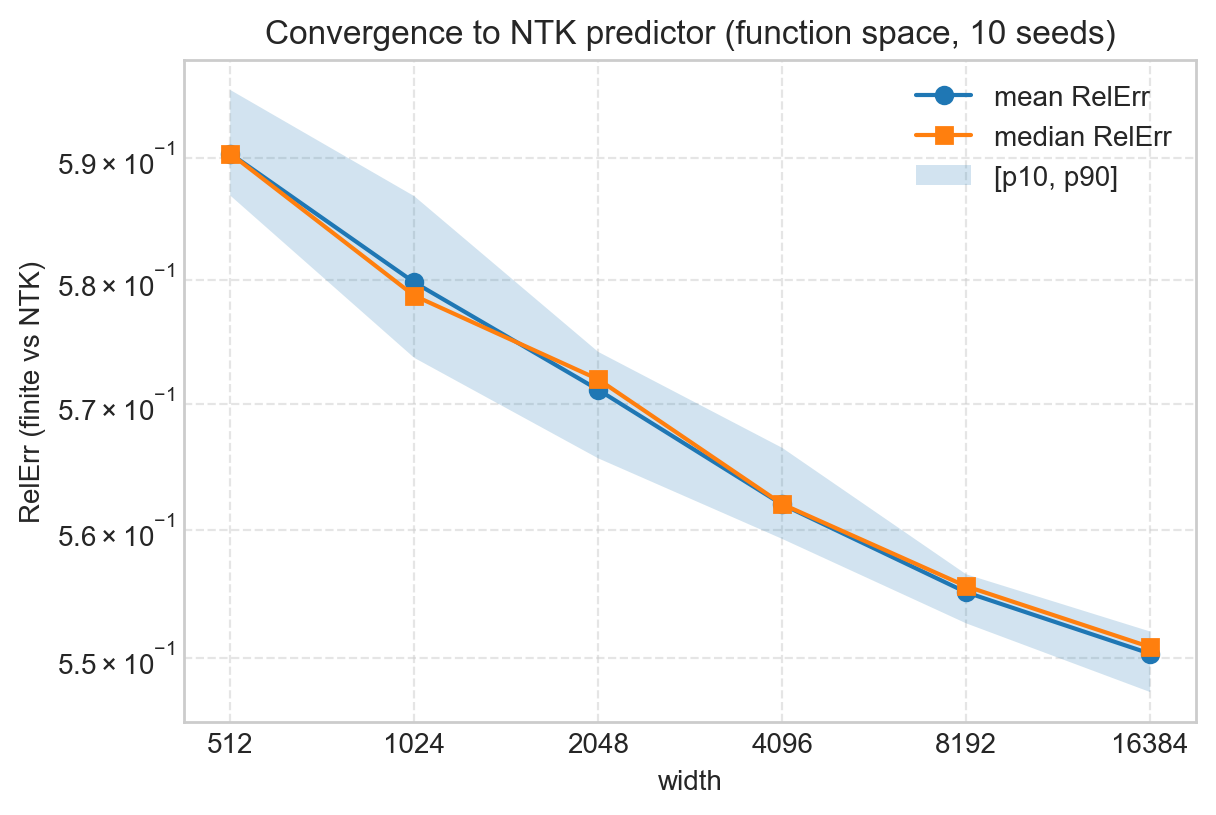

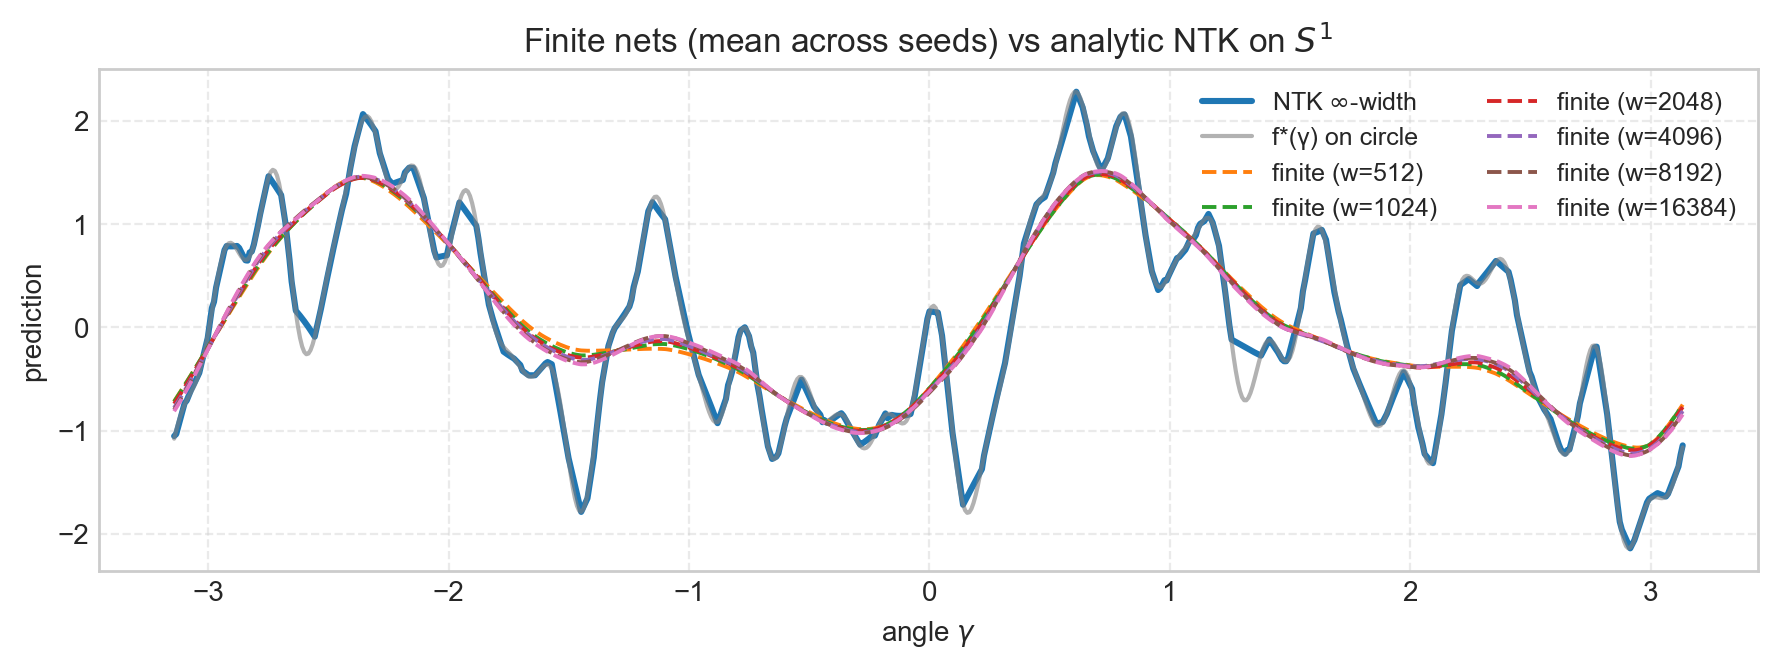

In [6]:
# plt.figure(figsize=(6.2,4.2))
# plt.loglog(ws, merr, marker='o', label='mean RelErr')
# plt.loglog(ws, p50, marker='s', label='median RelErr')
# plt.fill_between(ws, p10, p90, alpha=0.2, label='[p10, p90]')
# plt.xlabel('width'); plt.ylabel('RelErr (finite vs NTK)')
# plt.title('Convergence to NTK predictor (function space, 10 seeds)')
# plt.grid(True, which='both', ls='--', alpha=0.5); plt.legend()
# plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.loglog(ws, merr, marker='o', label='mean RelErr')
ax.loglog(ws, p50, marker='s', label='median RelErr')
ax.fill_between(ws, p10, p90, alpha=0.2, label='[p10, p90]')

# --- set ticks/labels on log-x ---
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(widths))
ax.xaxis.set_major_formatter(FixedFormatter([str(w) for w in widths]))
ax.xaxis.set_minor_locator(FixedLocator([]))

ax.set_xlabel('width')
ax.set_ylabel('RelErr (finite vs NTK)')
ax.set_title('Convergence to NTK predictor (function space, 10 seeds)')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()
fig.tight_layout()
plt.savefig("plots/rel-err-on-complex-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()

# 4) Overlay predictions: show NTK curve + per-width median (p50) and band (p10/p90).
gamma_np = np.asarray(gamma_eval)

# for w in widths:
#     s = stats[w]
#     plt.figure(figsize=(9,3.5))
#     plt.plot(gamma_np, np.asarray(y_inf), lw=2.2, label="NTK $\infty$-width")
#     plt.plot(gamma_np, s["pred_p50"], '--', lw=1.8, label=f'finite (w={w}) median')
#     plt.fill_between(gamma_np, s["pred_p10"], s["pred_p90"], alpha=0.15, label='finite p10–p90')
#     plt.xlabel(r'angle $\gamma$'); plt.ylabel('prediction')
#     plt.title(f'Finite nets vs analytic NTK on $S^1$ (width={w}, 10 seeds)')
#     plt.legend(); plt.grid(True, ls='--', alpha=0.4); plt.tight_layout(); plt.show()

# Overlay predictions
plt.figure(figsize=(9,3.5))
plt.plot(np.asarray(gamma_eval), np.asarray(y_inf), lw=2.2, label="NTK $\infty$-width")
plt.plot(np.asarray(gamma_eval), np.asarray(y_eval_true), color='gray', alpha=0.6, label='f*(γ) on circle')
for w in widths:
    s = stats[w]
    plt.plot(np.asarray(gamma_eval), s["preds"].mean(axis=0), '--', lw=1.4, label=f'finite (w={w})')
plt.xlabel(r'angle $\gamma$'); plt.ylabel('prediction')
plt.title('Finite nets (mean across seeds) vs analytic NTK on $S^1$')
plt.legend(ncol=2, fontsize=9); plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout(); 
plt.savefig("plots/convergence-on-complex-regression-task.png", dpi=300, bbox_inches="tight")
plt.show()